In [1]:
import os, sys
import torch
import numpy as np

from models import build_DABDETR, build_dab_deformable_detr
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or load an image from a local path(see Sec. 2).

# 0. Init and Load Pre-trained Models

In [2]:
model_config_path = "model_zoo/DAB_DETR/R50/config.json" # change the path of the model config file
model_checkpoint_path = "model_zoo/DAB_DETR/R50/checkpoint.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.


In [3]:
args = SLConfig.fromfile(model_config_path) 
model, criterion, postprocessors = build_DABDETR(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

# 1. Visualize images from dataloader
## 1.1 Load Datasets

In [4]:
dataset_val = build_dataset(image_set='val', args=args)
cocojs = dataset_val.coco.dataset
id2name = {item['id']: item['name'] for item in cocojs['categories']}

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


# 1.2 Get an Example and Visualize it

In [15]:
image, targets = dataset_val[0]

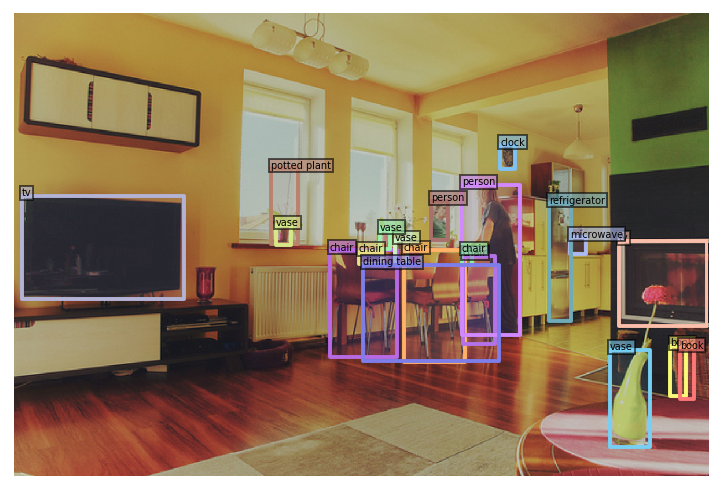

In [16]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [17]:
output = model(image[None])
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]))[0]

In [18]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

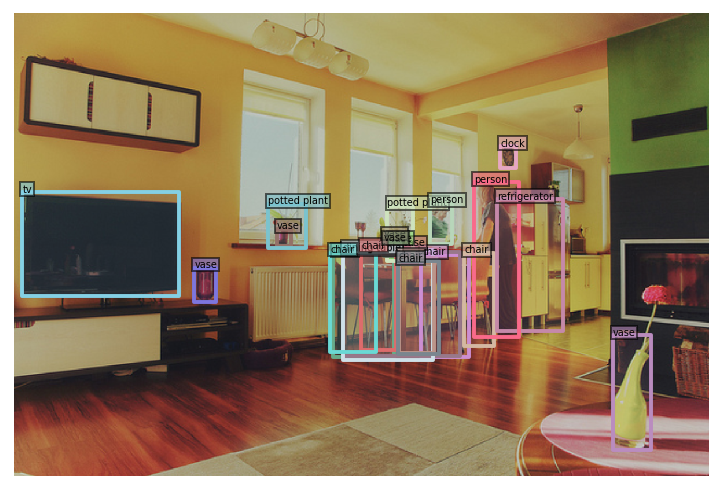

In [19]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [20]:
from PIL import Image
import datasets.transforms as T

In [21]:
image = Image.open("./figure/idea.jpg").convert("RGB")
# image

In [22]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [23]:
# predict images
output = model(image[None])
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]))[0]

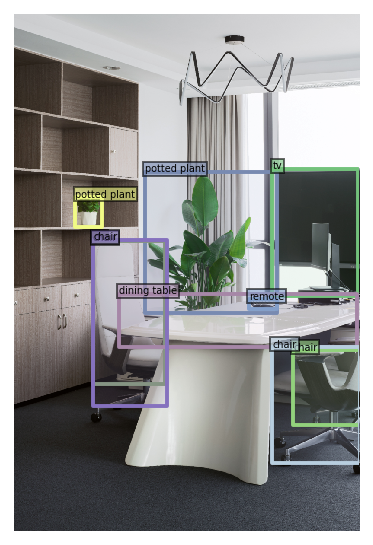

In [24]:
# visualize outputs
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)